In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 0. Полезные функции

In [3]:
def isnan(value):
    return value is None or value != value

In [4]:
def analyze(series, categorical: bool = None):
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]

    series_unique = sorted(series.unique())

    if categorical is None:
        categorical = len(series_unique) < 30

    max_len = 10

    print(
        f"unique: {len(series_unique)}",
        f"empty: {sum([isnan(el) for el in series])}",
        f"filled: {sum([not isnan(el) for el in series])},",
        f"values: {list(series_unique[:max_len]) + [] if len(series_unique) < max_len else ['...']}" if categorical else ""
    )
    if categorical:
        for val in series_unique[:max_len]:
            if isnan(val):
                print(f"{val} - {sum(series.isna())} times")
            else:
                print(f"{val} - {sum(series == val)} times")
        if len(series_unique) < 30:
            series.hist(xrot=-30)
    else:
        print(f"min: {series.min()}, mean: {series.mean()}, max: {series.max()}, std: {series.std()}")
        series.hist()
    plt.show()

# 1. Загрузка данных

In [5]:
df = pd.read_excel('dataset.xlsx')
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3460071768,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,['ХозОбор'],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000,0.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7704543951,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,['МедОбор'],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000,0.000000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,610601634808,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,['ХозМат'],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000,0.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6671095570,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,['МедМат'],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273,6555490.00,5.959536e+05,0.000000,0.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7726460307,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,['МедМат'],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5321065111,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"['ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги']",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000,0.000000
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6660139553,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"['МедМат', 'ХозМат']",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000,0.000000
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7207006570,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,['Другое'],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000,0.000000
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,463001373948,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,['МедМат'],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,97280

# 2. Собираем выборку поставщик-заказчик с рассчитанными признаками

In [6]:
print(list(df.columns))

['contract_guid', 'contract_is_complete', 'contract_extension', 'purchase_type_code', 'notice_lot_max_contract_price', 'notice_lot_initial_sum', 'region_name', 'notice_lot_currency_code', 'supplier_inn', 'supplier_type', 'contract_placer_inn', 'contract_rub_price', 'contract_price', 'contract_start_execution_date', 'contract_end_execution_date', 'contracts_for_lot', 'contract_positions_count', 'lot_guid', 'real_rub_price', 'real_initial_sum', 'position_category', 'contract_category', 'economy', 'economy_percent', 'total_placer_contracts', 'total_placer_with_supplier_contracts', 'percent_placer_with_supplier_contracts', 'total_supplier_contracts', 'percent_supplier_with_placer_contracts', 'max_contract_positions_placer_supplier', 'mean_contract_positions_placer_supplier', 'total_contract_sum_placer_supplier', 'mean_contract_sum_placer_supplier', 'min_economy_placer_supplier', 'mean_economy_placer_supplier']


unique: 82 empty: 0 filled: 781, 
min: -1.0, mean: -0.0026903171734242995, max: 0.83562, std: 0.1256088066368034


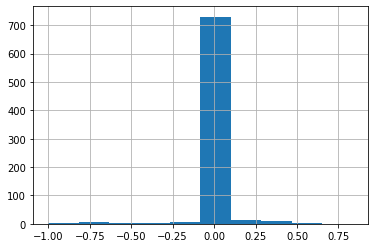

In [7]:
df = df[df['mean_economy_placer_supplier'] >= -1]
analyze(df[df['purchase_type_code'] == 30000]['mean_economy_placer_supplier'])


unique: 272 empty: 0 filled: 2103, 
min: -1.0, mean: 0.02488671676856374, max: 0.872799, std: 0.12546485018397194


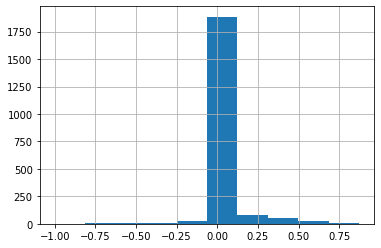

In [8]:
analyze(df[df['purchase_type_code'] == 40000]['mean_economy_placer_supplier'])

##### Рассчитанные признаки

In [9]:
calculated_features = [
    'mean_economy_placer_supplier',  # средняя экономия по лоту для пары
    'min_economy_placer_supplier',  # минимальная экономия по лоту для пары
    'mean_contract_sum_placer_supplier',  # средняя сумма договоров между заказчиком и поставщиком
    'total_contract_sum_placer_supplier',  # общая сумма договоров между заказчиком и поставщиком
    'mean_contract_positions_placer_supplier',  # среднее количество позиций в договоре для пары
    'max_contract_positions_placer_supplier',  # максимальное количество позиций в договоре для пары
    'percent_placer_with_supplier_contracts',  # процент договоров, которые заказчик заключил с этим поставщиком
    'percent_supplier_with_placer_contracts'  # процент договоров, которые поставщик заключил с этим заказчиком
]
supplier_placer = ['supplier_inn', 'contract_placer_inn']
df[calculated_features]

,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,0.000000,0.000000,2.435700e+05,243570.00,1.000000,1,0.250000,1.000000
1,0.000000,0.000000,5.145375e+05,5145375.13,1.600000,3,0.416667,0.370370
2,0.000000,0.000000,4.503636e+05,4954000.00,1.272727,4,0.239130,1.000000
3,0.000000,0.000000,5.959536e+05,6555490.00,1.727273,4,0.687500,1.000000
4,0.000000,0.000000,4.998500e+05,499850.00,1.000000,1,0.200000,1.000000
...,...,...,...,...,...,...,...,...
2886,0.000000,0.000000,9.749975e+05,974997.49,7.000000,7,1.000000,1.000000
2887,0.000000,0.000000,4.337124e+05,2168562.02,1.800000,3,0.555556,0.833333
2888,0.000000,0.000000,2.208919e+06,2208918.60,1.000000,1,0.035714,1.000000
2889,-0.122583,-0.247667,4.864000e+05,972800.00,1.000000,1,1.000000,1.000000


In [10]:
df['supplier_placer_count'] = df.groupby(supplier_placer)['supplier_inn'].transform('size')
df

/tmp/ipykernel_20802/33976561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['supplier_placer_count'] = df.groupby(supplier_placer)['supplier_inn'].transform('size')


,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier,supplier_placer_count
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3460071768,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,['ХозОбор'],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000,0.000000,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7704543951,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,['МедОбор'],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000,0.000000,10
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,610601634808,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,['ХозМат'],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000,0.000000,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6671095570,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,['МедМат'],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273,6555490.00,5.959536e+05,0.000000,0.000000,11
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7726460307,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,['МедМат'],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5321065111,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"['ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги']",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000,0.000000,1
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6660139553,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"['МедМат', 'ХозМат']",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000,0.000000,5
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7207006570,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,['Другое'],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000,0.000000,1
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,463001373948,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,['МедМат'],МедМат,-74300.0,-0.24

In [11]:
# Удалим пары, которые встречаются по одному разу. Так как на их основе не построить устойчивую связь
drop_single_supplier_placer = True
if drop_single_supplier_placer:
    df = df[df['supplier_placer_count'] > 1]
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier,supplier_placer_count
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7704543951,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,['МедОбор'],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,514537.513000,0.000000,0.000000,10
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,610601634808,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,['ХозМат'],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,450363.636364,0.000000,0.000000,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6671095570,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,['МедМат'],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273,6555490.00,595953.636364,0.000000,0.000000,11
5,00954370-200e-403a-997b-f469f075967e,NaN,0,30000,NaN,292407.00,Krasnodarskii_krai,RUB,2308185326,Юридическое лицо,2312210286,NaN,292407.00,2020-03-15,NaN,1,1,15fd6ba3-3df0-41da-b2ce-e2a8fef5800c,292407.00,292407.00,['Строительство'],Строительство,0.0,0.000000,50,20,0.400000,20,1.000000,1,1.000000,5470996.00,273549.800000,0.000000,0.000000,20
7,00a78395-bf17-4894-97fc-5ca229521d40,1.0,0,40000,NaN,122314.39,Saratovskaya_obl,RUB,6454074043,Юридическое лицо,6454006283,NaN,122314.39,NaN,NaN,1,1,e11b8e44-8990-4a5e-a77f-c8f4f2ec9632,122314.39,122314.39,['ХозУслуги'],ХозУслуги,0.0,0.000000,49,31,0.632653,31,1.000000,3,1.193548,4763018.69,153645.764194,0.000000,0.000000,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,fee6970b-505a-4e7d-bdae-3ebbabb7e723,1.0,0,40000,NaN,1500000.00,Moskva,RUB,7707300410,Юридическое лицо,7729101120,NaN,222615.00,2020-10-19,2020-12-30,1,1,3600b5fa-979b-4926-9694-3b5a4c15afd8,222615.00,1500000.00,['МедМат'],МедМат,1277385.0,0.851590,62,7,0.112903,7,1.000000,1,1.000000,4661277.45,665896.778571,0.030000,0.484802,7
2882,fee8f2e0-3a58-48cf-8990-20420d2ebc17,1.0,0,40000,NaN,406450.00,Tiumenskaya_obl,RUB,7203462204,Юридическое лицо,7207000070,NaN,406450.00,2020-04-06,2020-04-29,1,1,5a7a0e6c-b635-4d8f-bc82-895213b885e7,406450.00,406450.00,['МедМат'],МедМат,0.0,0.000000,4,3,0.750000,10,0.300000,1,1.000000,1318314.00,439438.000000,0.000000,0.000000,3
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6660139553,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"['МедМат', 'ХозМат']",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,433712.404000,0.000000,0.000000,5
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,463001373948,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,['МедМат'],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,486

In [12]:
df['supplier_inn'] = df.apply(
    lambda row: str(row['supplier_inn']),
    axis=1
)
df['contract_placer_inn'] = df.apply(
    lambda row: str(row['contract_placer_inn']),
    axis=1
)
df = df[supplier_placer + calculated_features].drop_duplicates()
df

/tmp/ipykernel_20802/4114672160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['supplier_inn'] = df.apply(
/tmp/ipykernel_20802/4114672160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contract_placer_inn'] = df.apply(


,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,7704543951,3525147496,0.000000,0.00000,5.145375e+05,5145375.13,1.600000,3,0.416667,0.370370
2,610601634808,6152000366,0.000000,0.00000,4.503636e+05,4954000.00,1.272727,4,0.239130,1.000000
3,6671095570,6623050480,0.000000,0.00000,5.959536e+05,6555490.00,1.727273,4,0.687500,1.000000
5,2308185326,2312210286,0.000000,0.00000,2.735498e+05,5470996.00,1.000000,1,0.400000,1.000000
7,6454074043,6454006283,0.000000,0.00000,1.536458e+05,4763018.69,1.193548,3,0.632653,1.000000
...,...,...,...,...,...,...,...,...,...,...
2549,7727803780,5036065113,0.001000,0.00100,2.066752e+07,41335033.60,1.000000,1,0.095238,1.000000
2555,7451344670,7453014519,0.000000,0.00000,3.023096e+06,6046193.00,3.000000,5,0.285714,1.000000
2636,772794006294,7729101120,0.410760,0.12952,2.561200e+06,5122400.00,1.000000,1,0.032258,1.000000
2661,1435157979,1435029085,0.000000,0.00000,1.000000e-02,0.02,1.000000,1,0.666667,0.666667


# 3. Анализ признаков и удаление выбросов

In [13]:
dataset = df

In [14]:
print(list(dataset.columns))

['supplier_inn', 'contract_placer_inn', 'mean_economy_placer_supplier', 'min_economy_placer_supplier', 'mean_contract_sum_placer_supplier', 'total_contract_sum_placer_supplier', 'mean_contract_positions_placer_supplier', 'max_contract_positions_placer_supplier', 'percent_placer_with_supplier_contracts', 'percent_supplier_with_placer_contracts']


### Средняя экономия по лоту для пары

unique: 104 empty: 0 filled: 449, 
min: -1.0, mean: 0.0058871849853964105, max: 0.83562, std: 0.1412370545259981


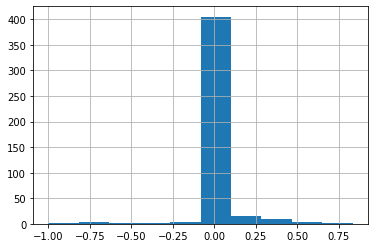

In [15]:
analyze(dataset['mean_economy_placer_supplier'])

### Минимальная экономия по лоту для пары

unique: 62 empty: 0 filled: 449, 
min: -2.071328671328671, mean: -0.02389857917803514, max: 0.75044, std: 0.19477470061811752


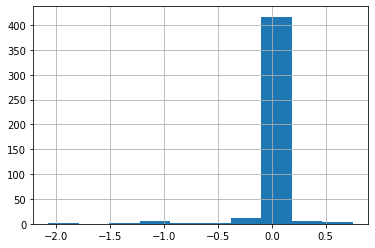

In [16]:
analyze(dataset['min_economy_placer_supplier'])

##### удаляем слишком большую экономию

In [17]:
dataset[dataset['min_economy_placer_supplier'] > 0.4]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
377,7701755549,7729101120,0.835620,0.750440,161390.0,322780.0,2.0,2,0.032258,1.0
599,7710258600,7729101120,0.733325,0.698104,133337.4,266674.8,1.0,1,0.032258,1.0
957,3851017720,3808069986,0.489841,0.475838,369790.0,739580.0,1.0,1,1.000000,1.0


In [18]:
dataset = dataset[dataset['min_economy_placer_supplier'] <= 0.4]


##### удаляем слишком маленькую экономию

In [19]:
dataset[dataset['min_economy_placer_supplier'] < -0.2]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
17,616511897803,6152000366,-0.035294,-0.666667,1.569713e+05,2.668512e+06,1.000000,1,0.369565,1.000000
28,4634010140,4632060153,-0.169607,-0.508820,3.348882e+06,1.004664e+07,1.000000,1,1.000000,1.000000
229,5017112368,3443012297,-0.166667,-1.000000,3.540612e+07,4.248734e+08,1.166667,2,0.240000,1.000000
265,7325019247,7328014430,-0.375000,-0.950000,7.731215e+05,1.546243e+06,1.000000,1,0.062500,1.000000
365,7326024095,7328041152,-0.627158,-1.254316,2.452407e+05,9.809629e+05,7.500000,11,1.000000,1.000000
675,6234166228,5260200603,-0.800000,-1.000000,7.908680e+05,3.954340e+06,1.000000,1,0.333333,1.000000
724,7713053544,901021165,-0.666667,-1.000000,3.996667e+06,1.199000e+07,1.666667,2,1.000000,0.230769
1344,2308108201,2308065678,-0.750000,-1.500000,6.984900e+06,1.396980e+07,1.000000,1,0.142857,1.000000
1356,6685024025,7203002479,-1.000000,-1.000000,3.000000e+05,6.000000e+05,1.000000,1,1.000000,0.200000
1434,645200138208,6449016286,-1.000000,-1.000000,1.400000e+05,2.800000e+05,1.000000,1,0.080000,1.000000


In [20]:
dataset = dataset[dataset['min_economy_placer_supplier'] >= -0.2]

##### удаляем нулевую экономию, так как она ничего не дает для анализа

### Средняя сумма договоров между заказчиком и поставщиком

unique: 424 empty: 0 filled: 432, 
min: 0.01, mean: 3883439.7732514907, max: 758274769.125, std: 37198580.652740695


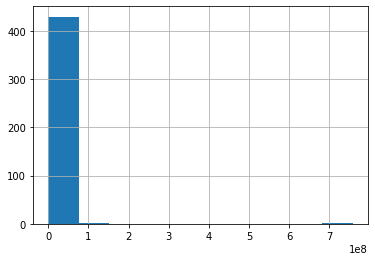

In [21]:
analyze(dataset['mean_contract_sum_placer_supplier'])

In [22]:
dataset[dataset['mean_contract_sum_placer_supplier'] > 7000000]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
62,7802684816,7838041248,0.000000e+00,0.000000,1.637367e+07,4.912100e+07,1.000000,1,0.200000,1.000000
101,3305795861,3325008103,0.000000e+00,0.000000,5.152500e+07,1.545750e+08,1.000000,1,0.100000,1.000000
148,7727391286,7705035012,0.000000e+00,0.000000,4.000000e+07,8.000000e+07,1.000000,1,0.066667,1.000000
169,7731373530,3201001120,0.000000e+00,0.000000,3.915960e+07,1.174788e+08,1.000000,1,0.013699,0.750000
204,6685139668,8905026850,0.000000e+00,0.000000,7.459024e+06,1.491805e+07,14.000000,27,0.142857,1.000000
235,7725328521,3443012297,0.000000e+00,0.000000,3.558117e+07,1.067435e+08,1.333333,2,0.060000,1.000000
284,7706814981,7705035012,0.000000e+00,0.000000,8.070000e+06,1.614000e+07,1.000000,1,0.066667,1.000000
432,5001061220,7830000426,4.502476e-02,0.044750,7.582748e+08,1.516550e+09,2.000000,2,0.040816,0.666667
490,3906115782,3903006520,5.644623e-07,0.000000,8.963331e+06,5.377998e+07,1.000000,1,1.000000,1.000000
499,7810308251,7838041248,1.666667e-02,0.000000,6.264161e+07,1.252832e+08,1.000000,1,0.133333,0.666667


In [23]:
dataset = dataset[dataset['mean_contract_sum_placer_supplier'] <= 7000000]

### Общая сумма договоров между заказчиком и поставщиком

unique: 441 empty: 0 filled: 449, 
min: 0.02, mean: 11344660.982227173, max: 1516549538.25, std: 76379684.32335496


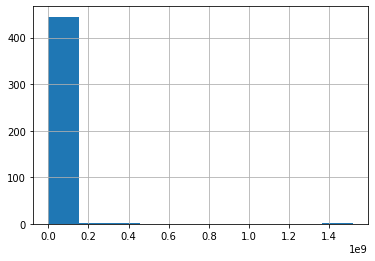

In [24]:
analyze(df['total_contract_sum_placer_supplier'])

### Среднее количество позиций в договоре для пары

unique: 55 empty: 0 filled: 413, 
min: 1.0, mean: 1.6047022517454537, max: 18.0, std: 1.7284867161867508


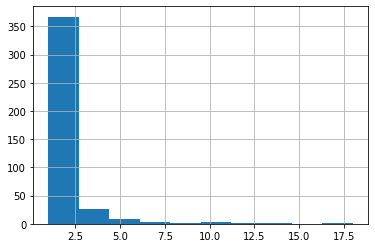

In [25]:
analyze(dataset['mean_contract_positions_placer_supplier'], categorical=False)

In [26]:
dataset[dataset['mean_contract_positions_placer_supplier'] > 10]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
108,2634059368,2633001291,0.000000,0.000000,239086.000,478172.00,13.0,13,0.285714,1.000000
267,7816363890,7806000721,0.041886,0.025975,212709.500,425419.00,11.0,21,0.333333,0.153846
846,7816363890,7806004042,0.027204,0.023933,144415.500,288831.00,12.0,23,0.333333,0.153846
1227,7709286850,3812014066,0.000000,0.000000,108419.400,216838.80,18.0,19,0.400000,1.000000
1679,2539071132,2539007634,0.000000,0.000000,228955.565,457911.13,11.0,19,0.400000,1.000000


In [27]:
dataset = dataset[dataset['mean_contract_positions_placer_supplier'] <= 10]

### Максимальное количество позиций в договоре для пары

unique: 17 empty: 0 filled: 408, 
min: 1, mean: 2.051470588235294, max: 34, std: 2.8697863174341625


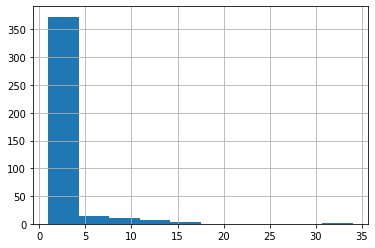

In [28]:
analyze(dataset['max_contract_positions_placer_supplier'], categorical=False)

### Процент договоров, которые заказчик заключил с этим поставщиком

unique: 115 empty: 0 filled: 408, 
min: 0.0091324200913242, mean: 0.33624814410791426, max: 1.0, std: 0.3201982364340941


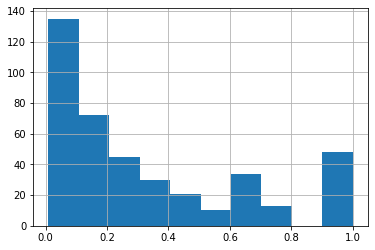

In [29]:
analyze(dataset['percent_placer_with_supplier_contracts'])

### Процент договоров, которые поставщик заключил с этим заказчиком

unique: 48 empty: 0 filled: 408, 
min: 0.04081632653061224, mean: 0.8431982355231655, max: 1.0, std: 0.2794947578657186


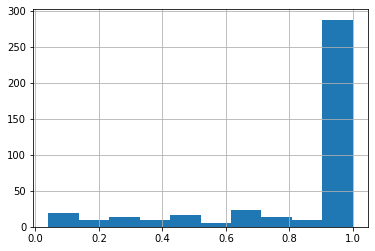

In [30]:
analyze(dataset['percent_supplier_with_placer_contracts'], categorical=False)

# 4. Стандартизируем признаки

In [31]:
data = dataset[calculated_features]
data = (data - data.mean()) / data.std()
data

,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,-0.241617,-0.015061,-0.382144,0.149157,0.117188,0.330523,0.251152,-1.691724
2,-0.241617,-0.015061,-0.434699,0.123735,-0.167017,0.678981,-0.303305,0.561019
3,-0.241617,-0.015061,-0.315468,0.336475,0.227712,0.678981,1.096982,0.561019
5,-0.241617,-0.015061,-0.579502,0.192412,-0.403855,-0.366393,0.199101,0.561019
7,-0.241617,-0.015061,-0.677698,0.098365,-0.235777,0.330523,0.925692,0.561019
...,...,...,...,...,...,...,...,...
2464,-0.171751,-0.015061,-0.572131,-0.459280,-0.403855,-0.366393,1.031919,0.561019
2555,-0.241617,-0.015061,1.672251,0.268820,1.332953,1.027439,-0.157821,0.561019
2636,5.393302,3.458707,1.293979,0.146105,-0.403855,-0.366393,-0.949381,0.561019
2661,-0.241617,-0.015061,-0.803527,-0.534347,-0.403855,-0.366393,1.031919,-0.631610


In [32]:
dataset[calculated_features] = data
dataset

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,7704543951,3525147496,-0.241617,-0.015061,-0.382144,0.149157,0.117188,0.330523,0.251152,-1.691724
2,610601634808,6152000366,-0.241617,-0.015061,-0.434699,0.123735,-0.167017,0.678981,-0.303305,0.561019
3,6671095570,6623050480,-0.241617,-0.015061,-0.315468,0.336475,0.227712,0.678981,1.096982,0.561019
5,2308185326,2312210286,-0.241617,-0.015061,-0.579502,0.192412,-0.403855,-0.366393,0.199101,0.561019
7,6454074043,6454006283,-0.241617,-0.015061,-0.677698,0.098365,-0.235777,0.330523,0.925692,0.561019
...,...,...,...,...,...,...,...,...,...,...
2464,4345316588,1826000260,-0.171751,-0.015061,-0.572131,-0.459280,-0.403855,-0.366393,1.031919,0.561019
2555,7451344670,7453014519,-0.241617,-0.015061,1.672251,0.268820,1.332953,1.027439,-0.157821,0.561019
2636,772794006294,7729101120,5.393302,3.458707,1.293979,0.146105,-0.403855,-0.366393,-0.949381,0.561019
2661,1435157979,1435029085,-0.241617,-0.015061,-0.803527,-0.534347,-0.403855,-0.366393,1.031919,-0.631610


# 5. Отбрасываем признаки, которые сильно коррелируют

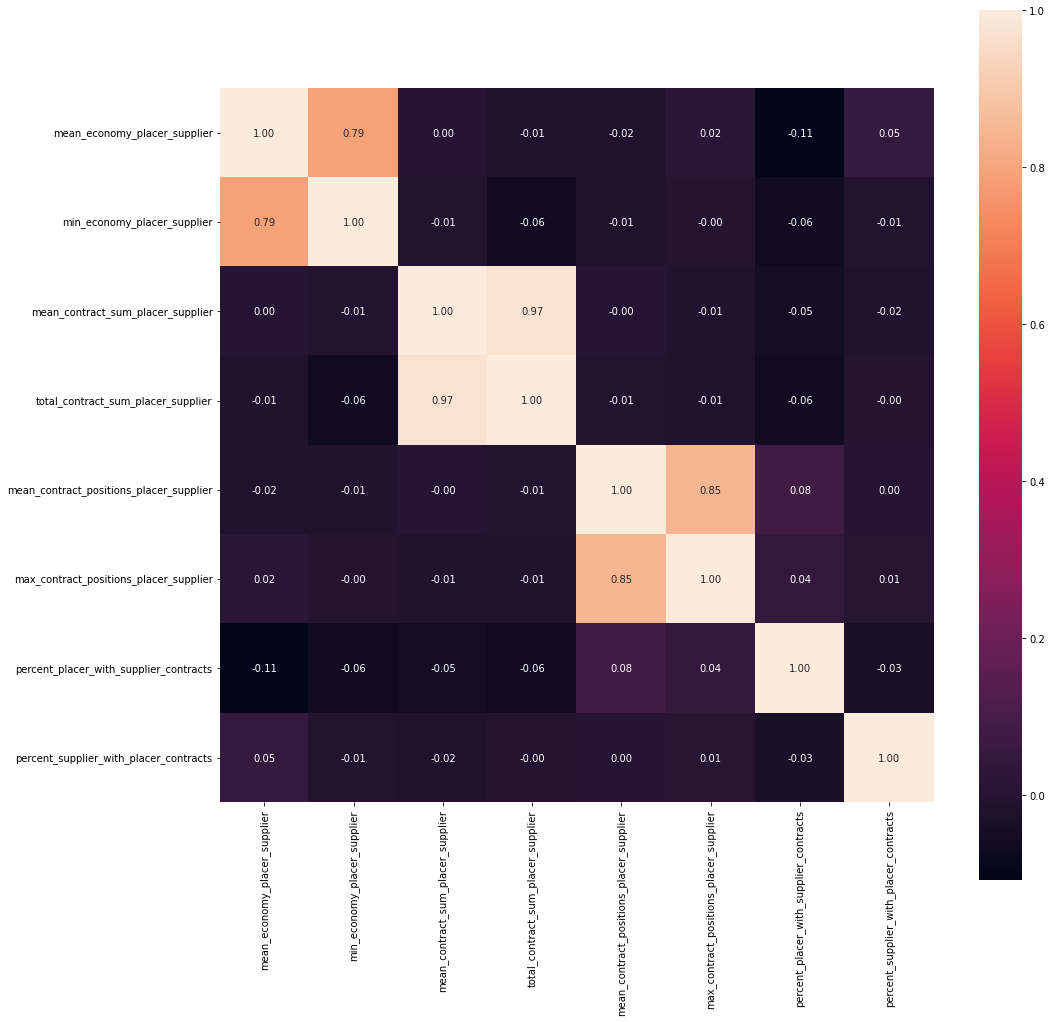

In [33]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, fmt='.2f', square=True)
plt.yticks(rotation='horizontal');

Видна корреляция между следующими признаками:

средняя экономия - минимальная экономия
средняя сумма - общая сумма
среднее количество позиций - максимальное количество позиций

In [34]:
columns = list(df.columns)
if 'min_economy_placer_supplier' in columns:
    columns.remove('min_economy_placer_supplier')
if 'total_contract_sum_placer_supplier' in columns:
    columns.remove('total_contract_sum_placer_supplier')
if 'max_contract_positions_placer_supplier' in columns:
    columns.remove('max_contract_positions_placer_supplier')
if 'min_economy_placer_supplier' in calculated_features:
    calculated_features.remove('min_economy_placer_supplier')
if 'total_contract_sum_placer_supplier' in calculated_features:
    calculated_features.remove('total_contract_sum_placer_supplier')
if 'max_contract_positions_placer_supplier' in calculated_features:
    calculated_features.remove('max_contract_positions_placer_supplier')
dataset = dataset[columns]
dataset

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,7704543951,3525147496,-0.241617,-0.382144,0.117188,0.251152,-1.691724
2,610601634808,6152000366,-0.241617,-0.434699,-0.167017,-0.303305,0.561019
3,6671095570,6623050480,-0.241617,-0.315468,0.227712,1.096982,0.561019
5,2308185326,2312210286,-0.241617,-0.579502,-0.403855,0.199101,0.561019
7,6454074043,6454006283,-0.241617,-0.677698,-0.235777,0.925692,0.561019
...,...,...,...,...,...,...,...
2464,4345316588,1826000260,-0.171751,-0.572131,-0.403855,1.031919,0.561019
2555,7451344670,7453014519,-0.241617,1.672251,1.332953,-0.157821,0.561019
2636,772794006294,7729101120,5.393302,1.293979,-0.403855,-0.949381,0.561019
2661,1435157979,1435029085,-0.241617,-0.803527,-0.403855,1.031919,-0.631610


# 6. Кластеризация

In [35]:
import scipy.cluster as clst

In [36]:
data = dataset[calculated_features]
data

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,-0.241617,-0.382144,0.117188,0.251152,-1.691724
2,-0.241617,-0.434699,-0.167017,-0.303305,0.561019
3,-0.241617,-0.315468,0.227712,1.096982,0.561019
5,-0.241617,-0.579502,-0.403855,0.199101,0.561019
7,-0.241617,-0.677698,-0.235777,0.925692,0.561019
...,...,...,...,...,...
2464,-0.171751,-0.572131,-0.403855,1.031919,0.561019
2555,-0.241617,1.672251,1.332953,-0.157821,0.561019
2636,5.393302,1.293979,-0.403855,-0.949381,0.561019
2661,-0.241617,-0.803527,-0.403855,1.031919,-0.631610


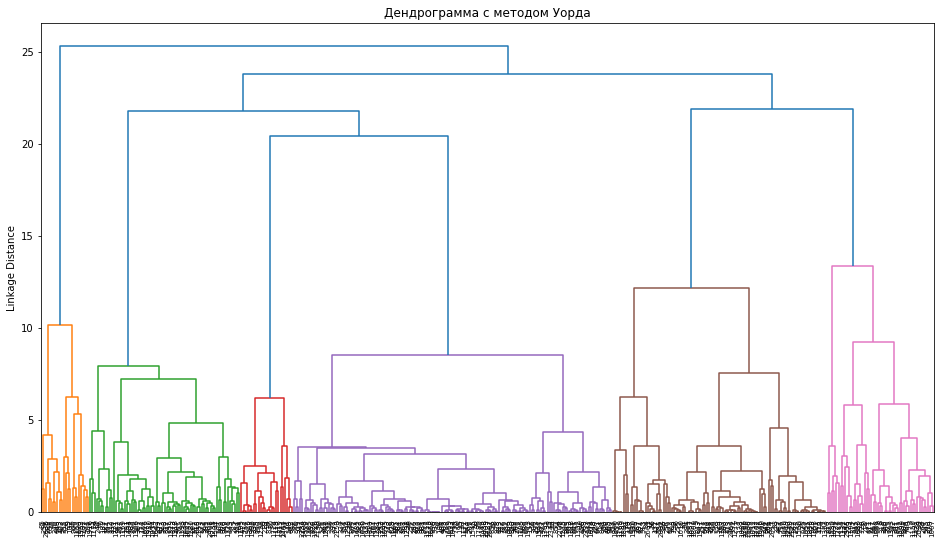

In [37]:
Z = clst.hierarchy.linkage(data, method='ward')
plt.figure(figsize=(16, 9))
dn = clst.hierarchy.dendrogram(Z, labels=data.index)
plt.xticks(rotation='vertical', fontsize=7)
plt.title('Дендрограмма с методом Уорда')
plt.ylabel('Linkage Distance');

In [38]:
from sklearn.cluster import AgglomerativeClustering

# Указать количество кластеров в параметре n_clusters
clust = AgglomerativeClustering(n_clusters=6, linkage='ward', affinity='euclidean')
dataset['cluster'] = clust.fit_predict(data)
dataset['cluster'].value_counts()

/tmp/ipykernel_20802/1672177548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cluster'] = clust.fit_predict(data)


2    146
1     98
4     69
0     49
5     24
3     22
Name: cluster, dtype: int64

In [39]:
# Сводная таблица средних значений по кластерам
pivot_table = dataset.groupby('cluster')[calculated_features].mean()
pivot_table

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
cluster,,,,,
0,-0.201726,-0.065836,2.096618,0.177105,0.370787
1,-0.246833,-0.392370,-0.305721,1.314716,-0.027808
2,-0.204020,-0.170975,-0.321178,-0.642000,0.558647
3,3.704014,-0.109909,-0.115164,-0.182337,0.077643
4,-0.227120,-0.031778,-0.226224,-0.527391,-1.617132
5,-0.081496,2.968799,-0.322442,-0.141124,0.536172


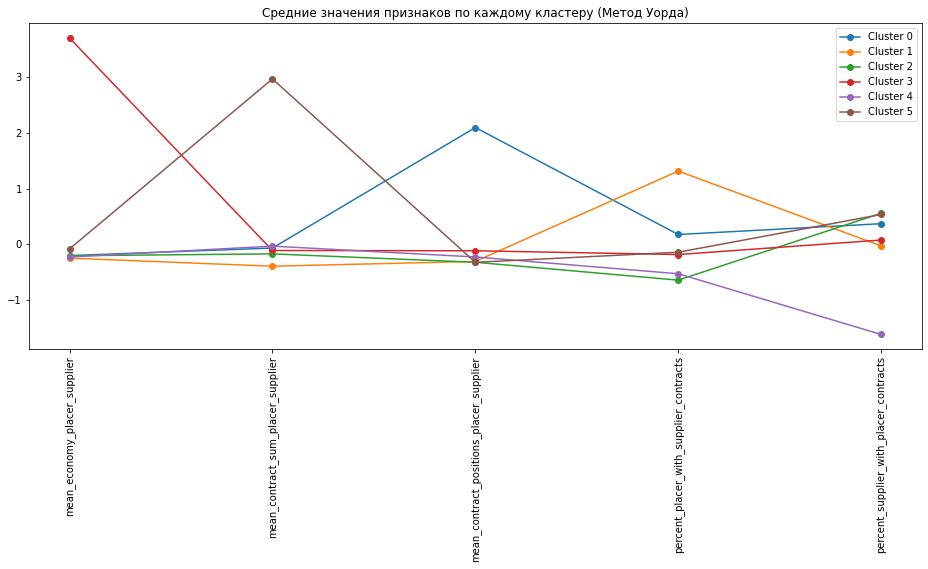

In [40]:
# Графики средних значений по кластерам

plt.figure(figsize=(16, 6))

for cluster in pivot_table.T.columns:
    plt.plot(pivot_table.T[cluster], 'o-', label=f'Cluster {cluster}')
plt.xticks(rotation='vertical')
plt.title('Средние значения признаков по каждому кластеру (Метод Уорда)')
plt.legend();

In [41]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=6)
dataset['cluster'] = clust.fit_predict(data)
dataset['cluster'].value_counts()

/tmp/ipykernel_20802/1666049322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cluster'] = clust.fit_predict(data)


1    177
2     87
3     66
5     43
0     19
4     16
Name: cluster, dtype: int64

In [42]:
# Сводная таблица средних значений по кластерам
pivot_table = dataset.groupby('cluster')[calculated_features].mean()
pivot_table

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
cluster,,,,,
0,-0.185797,0.025496,3.665604,0.617117,0.305809
1,-0.221441,-0.312944,-0.159263,-0.590895,0.439123
2,-0.185726,-0.411638,-0.248504,1.389457,0.315022
3,-0.071687,-0.216395,-0.164057,-0.116075,-2.024472
4,4.378564,0.030408,-0.115456,-0.519206,0.441756
5,-0.149822,2.430575,-0.166558,-0.280262,0.362908


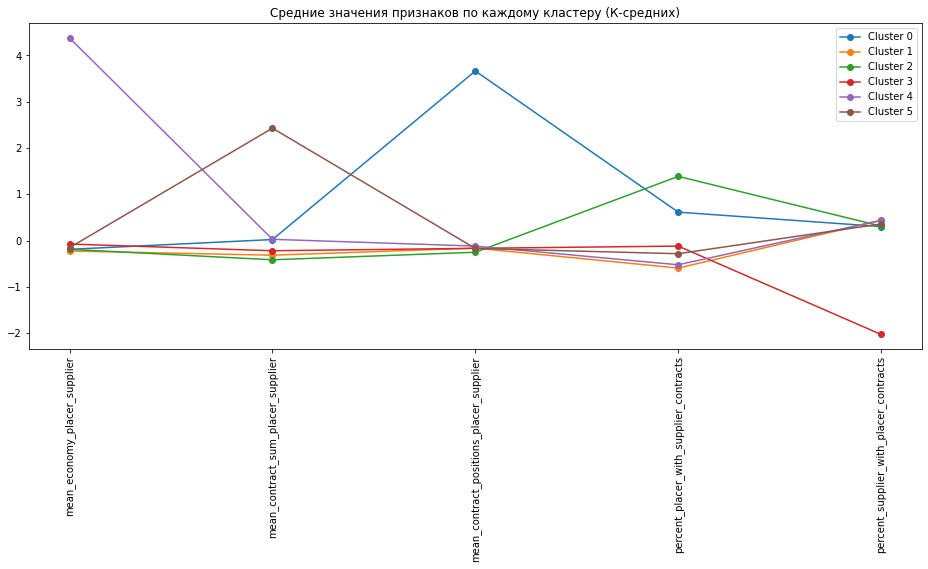

In [43]:
# Графики средних значений по кластерам

plt.figure(figsize=(16, 6))

for cluster in pivot_table.T.columns:
    plt.plot(pivot_table.T[cluster], 'o-', label=f'Cluster {cluster}')
plt.xticks(rotation='vertical')
plt.title('Средние значения признаков по каждому кластеру (К-средних)')
plt.legend();

In [44]:
cl = dataset[
    (dataset['cluster'] == 0)
    | (dataset['cluster'] == 1)
    | (dataset['cluster'] == 5)
]
data = cl[calculated_features]
cl

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts,cluster
2,610601634808,6152000366,-0.241617,-0.434699,-0.167017,-0.303305,0.561019,1
5,2308185326,2312210286,-0.241617,-0.579502,-0.403855,0.199101,0.561019,1
8,5408307196,4401053021,-0.241617,-0.327442,1.911890,-0.603973,0.561019,1
10,7728458261,3325008103,-0.241617,0.213000,-0.403855,-0.633716,0.561019,1
25,9717012574,7717022723,-0.241617,1.283403,-0.403855,-0.269359,0.561019,5
...,...,...,...,...,...,...,...,...
2333,7325000398,7328014430,-0.241617,0.167975,-0.403855,-0.757338,0.561019,1
2344,6230110577,6227004811,-0.241617,1.494348,-0.403855,0.199101,0.561019,5
2461,4345502070,4345086060,-0.241617,4.064456,-0.403855,2.072940,0.561019,5
2555,7451344670,7453014519,-0.241617,1.672251,1.332953,-0.157821,0.561019,5


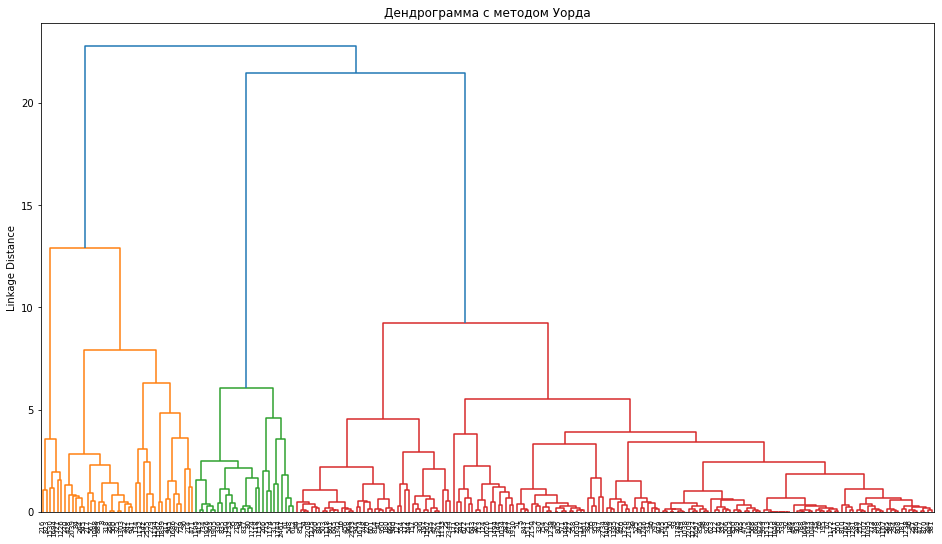

In [45]:
Z = clst.hierarchy.linkage(data, method='ward')
plt.figure(figsize=(16, 9))
dn = clst.hierarchy.dendrogram(Z, labels=data.index)
plt.xticks(rotation='vertical', fontsize=7)
plt.title('Дендрограмма с методом Уорда')
plt.ylabel('Linkage Distance');

In [46]:
clust = KMeans(n_clusters=3)
cl['cluster'] = clust.fit_predict(data)
cl['cluster'].value_counts()

/tmp/ipykernel_20802/3609151314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl['cluster'] = clust.fit_predict(data)


0    177
1     43
2     19
Name: cluster, dtype: int64

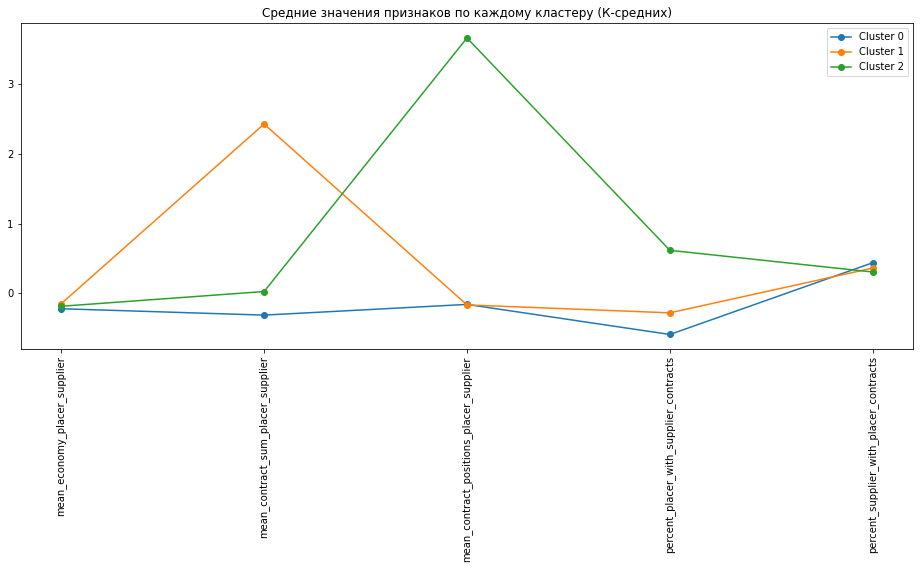

In [47]:
pivot_table = cl.groupby('cluster')[calculated_features].mean()

plt.figure(figsize=(16, 6))

for cluster in pivot_table.T.columns:
    plt.plot(pivot_table.T[cluster], 'o-', label=f'Cluster {cluster}')
plt.xticks(rotation='vertical')
plt.title('Средние значения признаков по каждому кластеру (К-средних)')
plt.legend();

In [48]:
cl[cl['cluster'] == 1]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts,cluster
25,9717012574,7717022723,-0.241617,1.283403,-0.403855,-0.269359,0.561019,1
55,7842033539,7830000426,-0.241617,1.634133,-0.403855,-0.795181,0.561019,1
61,7802642936,7812003110,-0.241617,3.610268,-0.403855,0.734484,0.561019,1
80,3257003746,3201001120,-0.241617,2.461122,-0.403855,-0.893259,0.561019,1
94,7810672363,7830000426,-0.241617,2.161686,-0.403855,-0.922653,0.561019,1
95,2466280572,2460213509,-0.241617,2.472290,-0.403855,-0.157821,0.561019,1
118,7725285067,3443012297,-0.091553,2.903078,0.681650,-0.800280,0.561019,1
142,7725628067,3443012297,-0.240694,3.513758,1.767156,-0.425512,0.561019,1
150,7203485321,7202032343,-0.241617,2.323060,-0.403855,-0.182607,-0.035295,1
157,3328404610,3325008103,-0.236985,1.643308,-0.403855,-0.425512,0.561019,1


Заказчик
6731000014 - https://www.rusprofile.ru/id/1314755 ОГУЭПП "Смоленскоблкоммунэнерго"
Поставщик
672403318182 - https://www.rusprofile.ru/ip/316673300064107 ИП Благовисный Павел Михайлович
6 договоров, заказчик и поставщик всегда вместе.
все договоры по аварийно-восстановительным работам с признаком emergency
таких договоров было 9, из них удалось определить поставщика по 6 и все с один ИП.
экономия в 6 договорах нулевая
есть предположения что имеет место сговор.

In [49]:
cl[cl['cluster'] == 5]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts,cluster


Заказчик:
4700000130 - https://www.rusprofile.ru/id/2690332 ЛОГП "Ленфарм"
Поставщик:
7810295612 - https://www.rusprofile.ru/id/2351785 ООО "Стальпроминвест"

В ковидную выборку от поставщика попало 12 договоров
по всем удалось найти поставщиков.

Из них 7 заключено со стальпроминвест.
Все 7 договоров имеют категорию медмат.
Предмет закупки у всех - Маска гигиеническая, трехслойная, одноразовая, производитель Китай.
Все договора были заключены с апреля по май 2020ого года.

Подозрительно:
1) Маски производства китая
2) Основная деятельность Стальпроминвест - Производство искусственного графита, коллоидного или полуколлоидного графита, продуктов на основе графита или прочих форм углерода в виде полуфабрикатов (23.99.4)
3) Все закупки имеют способ закупки иной способ, но на каждую закупку было подано по одной заявке
4) Нулевая экономия
5) в сумме было закуплено 1390860 масок на 33281660 рублей (23,9 рублей за маску)